In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
pd.set_option("display.precision", 15)
import numpy as np
plt.rcParams.update({'font.size': 22})
plt.rcParams['svg.fonttype'] = 'none'
from matplotlib.patches import Rectangle
from functools import reduce

def plot_change_against_sig_weighted(change, signatures, sig_weights,title):


    plt.figure(figsize=(10, 6))

    # Scatter plot
    '''
    for i in range(len(change)):
        plt.scatter(signatures[i], change[i], s=2000*sig_weights[i])
        '''
    plt.scatter(signatures, change, s=2000 * sig_weights)
    #xtick_labels = [sig if w > 0.02 or sig in ['SBS15', 'SBS6'] else '' for sig, w in zip(signatures, sig_weights)]
    xtick_labels = [sig if w > 0.02 else '' for sig, w in zip(signatures, sig_weights)]
    plt.xticks(ticks=range(len(signatures)), labels=xtick_labels, rotation=45)

    #np.array(sig_weights)
    #plt.plot(change, 'ko', markersize=1000 * sig_weights)
    plt.axhline(y=0, linestyle='-')
    plt.xticks(rotation=80, fontsize=13)
    plt.ylabel('$l^g, g \in \mathbf{cancer\ genes, HCLCA-human} $', fontsize=18)
    #plt.ylabel('$Delta^g, g \in \mathbf{cancer\ genes} $', fontsize=14)
    plt.xlabel('Signatures', fontsize=18)
    #plt.title('All sites', fontsize=16)
    plt.title(title, fontsize=20)
    x1,x2,y1,y2 = plt.axis()  
    plt.axis((x1,x2,-0.002,0.005))
    #plt.axis((x1,x2,-0.000015,0.000035))# for hclca-human #dpi=100, bbox_inches='tight'
    #plt.savefig(f'/home/maria/target_size_MRCA/output_graph/syn_syn.svg', format='svg')
    plt.show()

    return


def extract_avg_l_per_sig(file_path, species, cancer_genes_list):
    #looking at current human 
    files_list = glob.glob(f'{file_path}*')
    
    files_list.remove(f'{file_path}M_n_non_syn_muts')
    l_c = []
    l_nc = []
    signature = []

    for l_file in files_list:
        
        l_df = pd.read_csv(l_file, sep=',', header=None, index_col = 0  )
        
        #l_df = l_df[l_df.index.isin(extract_genes)]
        
        cg = set(cancer_genes_list)                      # faster membership
        mask = l_df.index.isin(cg)

        cancer_l_df = l_df[mask]
        mean_cancer_l = cancer_l_df.mean(numeric_only=True)
        #mean_cancer_l = cancer_l_df.mean(numeric_only=True).item() 
        l_c.append(mean_cancer_l.iat[0])

        non_cancer_l_df = l_df[~mask] 
        mean_non_cancer_l = non_cancer_l_df.mean(numeric_only=True)
        l_nc.append(mean_non_cancer_l.iat[0])

        signature_name = l_file[l_file.rindex('_')+1:]
        #when sig is single digit get issue 
        signature.append(signature_name) 
    print(f'number of genes is {len(l_df)}')
    #per signature, should only consider the driver cancer genes where signature is present? 
    #dict = {'signature': signature, 'l_c':l_c, 'l_nc': l_nc}
    dict = {'signature': signature, f'l_c_{species}':l_c, f'l_nc_{species}': l_nc}
    df = pd.DataFrame(dict)
    #results = df[~df.signature.isin(artefacts_sigs)]
    #results.sort_values(f'l_c_{species}', ascending=False, inplace=True)
    df.set_index('signature',inplace=True)
    return df

def plot_c_diff_against_nc_diff(c_diff, nc_diff, signatures, sig_weights,title):
    
    # Scatter plot
    plt.scatter(nc_diff, c_diff, s=1000 * sig_weights, color='k', alpha=1)  # 'k' is black
    
    #add line y=x
    plt.plot(nc_diff, nc_diff, linewidth=1, alpha =0.3, label = 'line y=x')

    # Determine plot limits
    y_min = min(c_diff)*1.1
    y_max = max(c_diff)*1.1
    x_min = min(nc_diff)*1.1
    x_max = max(nc_diff)*1.1

    #optional-input limits
    y_min = -0.001
    y_max = 0.005
    x_min = -0.001
    x_max=0.007

    # Add shaded background rectangles
    ax = plt.gca()  # get current axes
    # Bottom-left 
    ax.add_patch(Rectangle((x_min, y_min), 0 - x_min, 0 - y_min, color='red', alpha=0.1,label='c increase in mutability'))
    # Bottom-right 
    ax.add_patch(Rectangle((0, y_min), x_max - 0, 0 - y_min, color='red', alpha=0.1))
    # Top-right (Red)
    ax.add_patch(Rectangle((0, 0), x_max - 0, y_max - 0, color='green', alpha=0.1, label='c decrease in mutability'))
    # Top-left (Yellow)
    ax.add_patch(Rectangle((x_min, 0), 0 - x_min, y_max - 0, color='green', alpha=0.1))

    # Axes lines
    plt.axvline(x=0, linestyle='-', color='black')
    plt.axhline(y=0, linestyle='-', color='black')

    # Labels
    #plt.rcParams['text.usetex'] = True
    plt.xlabel('$\Delta l^g, g \in \mathbf{non\ cancer\ genes}$')
    plt.ylabel('$\Delta l^g, g \in \mathbf{cancer\ genes}$')
    plt.title(title)

    # Signature labels for most impt sigs
    for i, sig in enumerate(signatures):
        if sig_weights[i]>0.01:
        #if sig_weights[i]>0.000:
            if sig=='SBS10b':
                print(sig)
                print(nc_diff[i])
                print(c_diff[i])
            plt.text(nc_diff[i], c_diff[i], sig[3:], fontsize=12, ha='right', va='bottom', alpha=1)
    #, alpha=0.4+sig_weights[i]*3
    
    #shaing region, x<y<0
    
    # Generate x values from the intersection of y=x and y=0 (i.e., where y = x < 0)
    x_fill = np.linspace(x_min, 0, 500)
    y1 = x_fill       # lower bound: y = x
    y2 = np.zeros_like(x_fill)  # upper bound: y = 0

    # Fill between y = x and y = 0, only where y < 0 and x < y
    plt.fill_between(x_fill, y1, y2, color='yellow', alpha=0.2, label='smaller increase in c mutability than nc')

    # Set axis limits
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.legend(fontsize=12)
    plt.tight_layout()

    plt.show()

    return

def plot_c_diff_against_nc_diff_error_bars(c_diff, nc_diff, c_errors, nc_errrors, signatures, sig_weights,title):
    
    # Scatter plot
    plt.errorbar(nc_diff, c_diff, xerr=nc_errrors,yerr=c_errors,fmt='none',alpha=0.6)  
    plt.scatter(nc_diff, c_diff,s=1000 * sig_weights, color='k', alpha=1)
    # 'k' is black
    
    #add line y=x
    plt.plot(nc_diff, nc_diff, linewidth=1, alpha =0.3, label = 'line y=x')

    # Determine plot limits
    y_min = min(c_diff)*1.1
    y_max = max(c_diff)*1.1
    x_min = min(nc_diff)*1.1
    x_max = max(nc_diff)*1.1

    #optional-input limits
    y_min = -0.001
    y_max = 0.005
    x_min = -0.001
    x_max=0.007

    # Add shaded background rectangles
    ax = plt.gca()  # get current axes
    # Bottom-left 
    ax.add_patch(Rectangle((x_min, y_min), 0 - x_min, 0 - y_min, color='red', alpha=0.1,label='c increase in mutability'))
    # Bottom-right 
    ax.add_patch(Rectangle((0, y_min), x_max - 0, 0 - y_min, color='red', alpha=0.1))
    # Top-right (Red)
    ax.add_patch(Rectangle((0, 0), x_max - 0, y_max - 0, color='green', alpha=0.1, label='c decrease in mutability'))
    # Top-left (Yellow)
    ax.add_patch(Rectangle((x_min, 0), 0 - x_min, y_max - 0, color='green', alpha=0.1))

    # Axes lines
    plt.axvline(x=0, linestyle='-', color='black')
    plt.axhline(y=0, linestyle='-', color='black')

    # Labels
    #plt.rcParams['text.usetex'] = True
    plt.xlabel('$\Delta l^g, g \in \mathbf{non\ cancer\ genes}$')
    plt.ylabel('$\Delta l^g, g \in \mathbf{cancer\ genes}$')
    plt.title(title)

    # Signature labels for most impt sigs
    for i, sig in enumerate(signatures):
        if sig_weights[i]>0.01:
        #if sig_weights[i]>0.000:
            if sig=='SBS10b':
                print(sig)
                print(nc_diff[i])
                print(c_diff[i])
            plt.text(nc_diff[i], c_diff[i], sig[3:], fontsize=12, ha='right', va='bottom', alpha=1)
    #, alpha=0.4+sig_weights[i]*3
    
    #shaing region, x<y<0
    
    # Generate x values from the intersection of y=x and y=0 (i.e., where y = x < 0)
    x_fill = np.linspace(x_min, 0, 500)
    y1 = x_fill       # lower bound: y = x
    y2 = np.zeros_like(x_fill)  # upper bound: y = 0

    # Fill between y = x and y = 0, only where y < 0 and x < y
    plt.fill_between(x_fill, y1, y2, color='yellow', alpha=0.2, label='smaller increase in c mutability than nc')

    # Set axis limits
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.legend(fontsize=12)
    plt.tight_layout()

    plt.show()

    return

def extract_avg_l_per_sig_matched_genes(file_path, species, matched_gene_df, gene_dict):
    cancer_genes_list=matched_gene_df.index.to_list()
    
    files_list = glob.glob(f'{file_path}*')
    files_list.remove(f'{file_path}M_n_non_syn_muts')

    l_c = []
    l_nc = []
    signature = []

    l_df1 = pd.read_csv(files_list[0], sep=',', header=None, index_col = 0)
    l_df1 = l_df1.rename(index=gene_dict)
    all_genes = l_df1.index
    cancer_genes_recon = list(set(cancer_genes_list)&set(all_genes))
    matched_genes = []
    cancer_genes_extract=[]
    for cancer_gene in cancer_genes_recon:
        cancer_df = matched_gene_df.loc[cancer_gene]
        cancer_df = cancer_df[cancer_df['matched_gene'].isin(all_genes)].copy()
        if isinstance(cancer_df, pd.DataFrame) and len(cancer_df) > 1:
            cancer_df.sort_values(by=['distance'],inplace=True)
            #first entry should always be cancer gene itself
            matched_gene = cancer_df['matched_gene'].iloc[1]

            matched_genes.append(matched_gene)
            cancer_genes_extract.append(cancer_gene)
    
    for l_file in files_list:
        l_df = pd.read_csv(l_file, sep=',', header=None, index_col = 0  )
        l_df = l_df.rename(index=gene_dict)
        cancer_l_df = l_df[l_df.index.isin(cancer_genes_extract)]
        mean_cancer_l = cancer_l_df.mean()
        l_c.append(mean_cancer_l.iat[0])
        
        #chossing non cancer genes from best match of df
        non_cancer_l_df = l_df[l_df.index.isin(matched_genes)] 
        mean_non_cancer_l = non_cancer_l_df.mean()
        l_nc.append(mean_non_cancer_l.iat[0])
        
        signature_name =  l_file[l_file.rindex('_')+1:]
        signature.append(signature_name) 

    #per signature, should only consider the driver cancer genes where signature is present? 
    #dict = {'signature': signature, 'l_c':l_c, 'l_nc': l_nc}
    dict = {'signature': signature, f'l_c_{species}':l_c, f'l_nc_{species}': l_nc}
    df = pd.DataFrame(dict)
    #results = df[~df.signature.isin(artefacts_sigs)]
    #results.sort_values(f'l_c_{species}', ascending=False, inplace=True)
    df.set_index('signature',inplace=True)
    return df

def extract_sigs_per_gene(file_path):

    #looking at current human 
    
    files_list = glob.glob(f'{file_path}*')
    unnamed_file = f'{file_path}l_Unnamed: 0'
    if unnamed_file in files_list:
        files_list.remove(unnamed_file)
    files_list.remove(f'{file_path}M_n_non_syn_muts')

    sig_dfs ={}
    for l_file in files_list:
        sig = l_file[l_file.rindex('_')+1:]
        
        l_df_all = pd.read_csv(l_file, sep=',', names=['gene', f'{sig}'], index_col = 0  )
        
        
        sig_dfs[l_file] = l_df_all
    
    merged_df = reduce(lambda left, right: left.join(right, how ='inner'),
                   sig_dfs.values())
    
    return merged_df

def extract_avg_l_per_sig_all_from_gene_list(file_path, species, gene_list):
    #looking at current human 
    files_list = glob.glob(f'{file_path}*')
    unnamed_file = f'{file_path}l_Unnamed: 0'
    if unnamed_file in files_list:
        files_list.remove(f'{file_path}l_Unnamed: 0')
    files_list.remove(f'{file_path}M_n_non_syn_muts')

    l = []
    signature = []

    for l_file in files_list:
        
        l_df = pd.read_csv(l_file, sep=',', header=None, index_col = 0)
        intersect_l_df = l_df[l_df.index.isin(gene_list)]
        
        mean_l = intersect_l_df.mean()
        l.append(mean_l.iat[0])

        signature_name = l_file[l_file.rindex('_')+1:]
        signature.append(signature_name)
         

    #per signature, should only consider the driver cancer genes where signature is present? 
    #dict = {'signature': signature, 'l_c':l_c, 'l_nc': l_nc}
    dict = {'signature': signature, f'l_{species}':l}
    df = pd.DataFrame(dict)
    df.sort_values(f'l_{species}', ascending=False, inplace=True)
    return df

# Extract the dataframes for each species
def extract_df_per_species_gene_subset(species_filepaths, cancer_gene_list, plot, subset_included, name, base_species):
    species_genes_dict = {}
    for species, path in species_filepaths.items():
        l_df = pd.read_csv(f'{path}l_SBS1', sep=',', header=None, index_col = 0)
        species_genes_dict[species] = set(l_df.index)
        
      
    # Get the intersection of all gene lists
    
    common_genes = set.intersection(*map(set, species_genes_dict.values()))
    print(common_genes)
    
    if subset_included ==1:
        common_cancer_genes = set.intersection(common_genes, cancer_gene_list)

    #to extract all genes but those given in the list
    if subset_included ==0:
        common_cancer_genes = common_genes - set(cancer_gene_list)
    
    # Convert back to a list (optional)
    common_cancer_genes = list(common_cancer_genes)
    
    print(common_cancer_genes)
    print(len(common_cancer_genes))

    #extract species df, using same genes for all species
    species_cancer_dfs = {}
    for species, path in species_filepaths.items():
        species_cancer_dfs[species] = extract_avg_l_per_sig_all_from_gene_list(path, f'{species}_{name}',common_cancer_genes)
        
    # Merge all dataframes on 'signature'
    cancer_merged_df = reduce(lambda left, right: left.merge(right, on='signature'),
                    species_cancer_dfs.values())
    cancer_merged_df = cancer_merged_df.set_index('signature')
     # Choose a base species (e.g., human) for comparison

    l_base = cancer_merged_df[f'l_{base_species}_{name}'].values

    # Loop over each species (other than the base species) and plot on a new figure
    l_human_diffs = {}
    # Get the signature array for plotting
    signature = cancer_merged_df.index.values
    for species in species_filepaths:
        #if species == base_species:
            #continue
        
        l_species = cancer_merged_df[f'l_{species}_{name}'].values
        #SBS1= cancer_merged_df[f'l_{species}_{name}']['SBS1']
        weighted_sum = 0.4*cancer_merged_df[f'l_{species}_{name}']['SBS1'] + 0.3*cancer_merged_df[f'l_{species}_{name}']['SBS5'] + 0.1*cancer_merged_df[f'l_{species}_{name}']['SBS2'] + 0.1*cancer_merged_df[f'l_{species}_{name}']['SBS13']+ 0.04*cancer_merged_df[f'l_{species}_{name}']['SBS40a']+ 0.03*cancer_merged_df[f'l_{species}_{name}']['SBS40b']+ 0.03*cancer_merged_df[f'l_{species}_{name}']['SBS40c']

        sum = np.sum(l_species)
        
        l_human_diffs[species] = weighted_sum
        if plot ==1:
            plt.figure()  # Create a new figure for each plot
            #plot_x_against_y(l_base, l_species, signature, f'l_{base_species}', f'l_{species}')
    #l_human_diffs['human'] = np.sum(cancer_merged_df[f'l_human_cancer'].values)
    #l_human_diffs['human'] = cancer_merged_df[f'l_human_cancer']['SBS1']
    human_diff_df = pd.DataFrame.from_dict(l_human_diffs, orient='index', columns=[f'l_sum_{name}'])
    
    return cancer_merged_df, human_diff_df


<>:30: SyntaxWarning: invalid escape sequence '\i'
<>:121: SyntaxWarning: invalid escape sequence '\D'
<>:122: SyntaxWarning: invalid escape sequence '\D'
<>:195: SyntaxWarning: invalid escape sequence '\D'
<>:196: SyntaxWarning: invalid escape sequence '\D'
<>:30: SyntaxWarning: invalid escape sequence '\i'
<>:121: SyntaxWarning: invalid escape sequence '\D'
<>:122: SyntaxWarning: invalid escape sequence '\D'
<>:195: SyntaxWarning: invalid escape sequence '\D'
<>:196: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_12698/211290483.py:30: SyntaxWarning: invalid escape sequence '\i'
  plt.ylabel('$l^g, g \in \mathbf{cancer\ genes, HCLCA-human} $', fontsize=18)
/tmp/ipykernel_12698/211290483.py:121: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel('$\Delta l^g, g \in \mathbf{non\ cancer\ genes}$')
/tmp/ipykernel_12698/211290483.py:122: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta l^g, g \in \mathbf{cancer\ genes}$')
/tmp/ipykernel_12698/211290483.p

plot per simulation graphs

In [ ]:
cancer_genes = '/home/maria/run_simulations/data/Cosmic_CancerGeneCensus_names.txt'
gene_ids = '/home/maria/cactus_target_size/auxillary/gene_name_id.csv'
weights_file = '/home/maria/data/signature_weights/calc_mut_weights.csv'


HCLCA_file ='/home/maria/run_simulations_cactus/output_anc4_hg38/Anc4/'
homo_file ="/home/maria/run_simulations_cactus/output_anc4_hg38/sim_{x}/"
title = 'HCLCA-human, simulated'

gene_id_df = pd.read_csv(gene_ids)

cancer_genes_df = pd.read_csv(cancer_genes, names=['gene_name'])
#convert cancer genes to ensembl gene ids
cancer_id_df = cancer_genes_df.merge(gene_id_df, on=['gene_name'], how='inner')
cancer_genes_list = cancer_id_df['gene'].tolist()
filtered_sum = pd.read_csv(weights_file, index_col=0, names=['norm_weight'])
HCLCA_df = extract_avg_l_per_sig(HCLCA_file, 'HCLCA', cancer_genes_list)

for i in range(10):
    human_df = extract_avg_l_per_sig(homo_file.format(x=i), 'human', cancer_genes_list)
    merged_df = human_df.join(HCLCA_df)

    weight_merged_df = merged_df.join(filtered_sum, how='inner')
    weight_merged_df['c_Delta'] = (weight_merged_df['l_c_HCLCA']-weight_merged_df['l_c_human'])/( weight_merged_df['l_c_HCLCA']+weight_merged_df['l_c_human'])
    weight_merged_df['nc_Delta'] = (weight_merged_df['l_nc_HCLCA']-weight_merged_df['l_nc_human'])/(weight_merged_df['l_nc_HCLCA']+weight_merged_df['l_nc_human'])


    plt.figure(figsize=(9,9))
    plot_c_diff_against_nc_diff(weight_merged_df['c_Delta'], weight_merged_df['nc_Delta'], weight_merged_df.index, weight_merged_df['norm_weight'], title)




comparing to actual human sequence-from run WITH CPG ISLANDS-cannot compare 

number of genes is 17453
number of genes is 17453
SBS10b
0.00438381416476592
0.0032097887164219854


/tmp/ipykernel_12698/211290483.py:127: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if sig_weights[i]>0.01:
/tmp/ipykernel_12698/211290483.py:133: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(nc_diff[i], c_diff[i], sig[3:], fontsize=12, ha='right', va='bottom', alpha=1)
/tmp/ipykernel_12698/211290483.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(nc_diff[i])
/tmp/ipykernel_12698/211290483.py:132: FutureWarnin

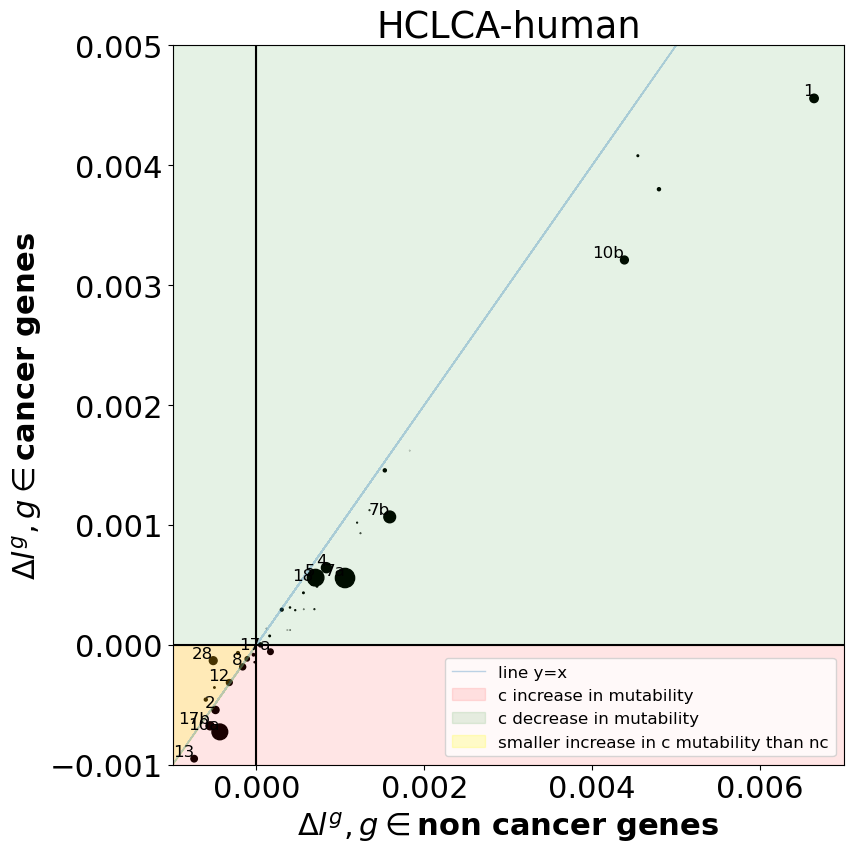

In [2]:
cancer_genes = '/home/maria/run_simulations/data/Cosmic_CancerGeneCensus_names.txt'
gene_ids = '/home/maria/cactus_target_size/auxillary/gene_name_id.csv'
weights_file = '/home/maria/data/signature_weights/calc_mut_weights.csv'


homo_file = '/home/maria/run_simulations_cactus/output_anc4_hg38/hg38/'
#homo_file = '/home/maria/run_simulations_cactus/output_anc4_hg38/Anc4/'
HCLCA_file='/home/maria/run_simulations_cactus/output_anc4_hg38/Anc4/'
title = 'HCLCA-human'


gene_id_df = pd.read_csv(gene_ids)

cancer_genes_df = pd.read_csv(cancer_genes, names=['gene_name'])
#convert cancer genes to ensembl gene ids
cancer_id_df = cancer_genes_df.merge(gene_id_df, on=['gene_name'], how='inner')
cancer_genes_list = cancer_id_df['gene'].tolist()

human_df = extract_avg_l_per_sig(homo_file, 'human', cancer_genes_list)
HCLCA_df = extract_avg_l_per_sig(HCLCA_file, 'HCLCA', cancer_genes_list)
merged_df = human_df.join(HCLCA_df)

filtered_sum = pd.read_csv(weights_file, index_col=0, names=['norm_weight'])
weight_merged_df = merged_df.join(filtered_sum, how='inner')
weight_merged_df['c_Delta'] = (weight_merged_df['l_c_HCLCA']-weight_merged_df['l_c_human'])/( weight_merged_df['l_c_HCLCA']+weight_merged_df['l_c_human'])
weight_merged_df['nc_Delta'] = (weight_merged_df['l_nc_HCLCA']-weight_merged_df['l_nc_human'])/(weight_merged_df['l_nc_HCLCA']+weight_merged_df['l_nc_human'])


plt.figure(figsize=(9,9))
plot_c_diff_against_nc_diff(weight_merged_df['c_Delta'], weight_merged_df['nc_Delta'], weight_merged_df.index, weight_merged_df['norm_weight'], title)


creating error bars

from multiple simulations extract the quanitiles of distributions
to get a 'prediction interval'

currently plotting with one standard error

number of genes is 18311
number of genes is 18311
number of genes is 18311
number of genes is 18311
number of genes is 18311
number of genes is 18311
number of genes is 18311
number of genes is 18311
number of genes is 18311
number of genes is 18311
number of genes is 18311
number of genes is 18311
number of genes is 18311
number of genes is 18311
number of genes is 18311
SBS10b
0.00441331334494125
0.0034555497028139425


/tmp/ipykernel_1569911/211290483.py:201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if sig_weights[i]>0.01:
/tmp/ipykernel_1569911/211290483.py:207: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(nc_diff[i], c_diff[i], sig[3:], fontsize=12, ha='right', va='bottom', alpha=1)
/tmp/ipykernel_1569911/211290483.py:205: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(nc_diff[i])
/tmp/ipykernel_1569911/211290483.py:206: Futu

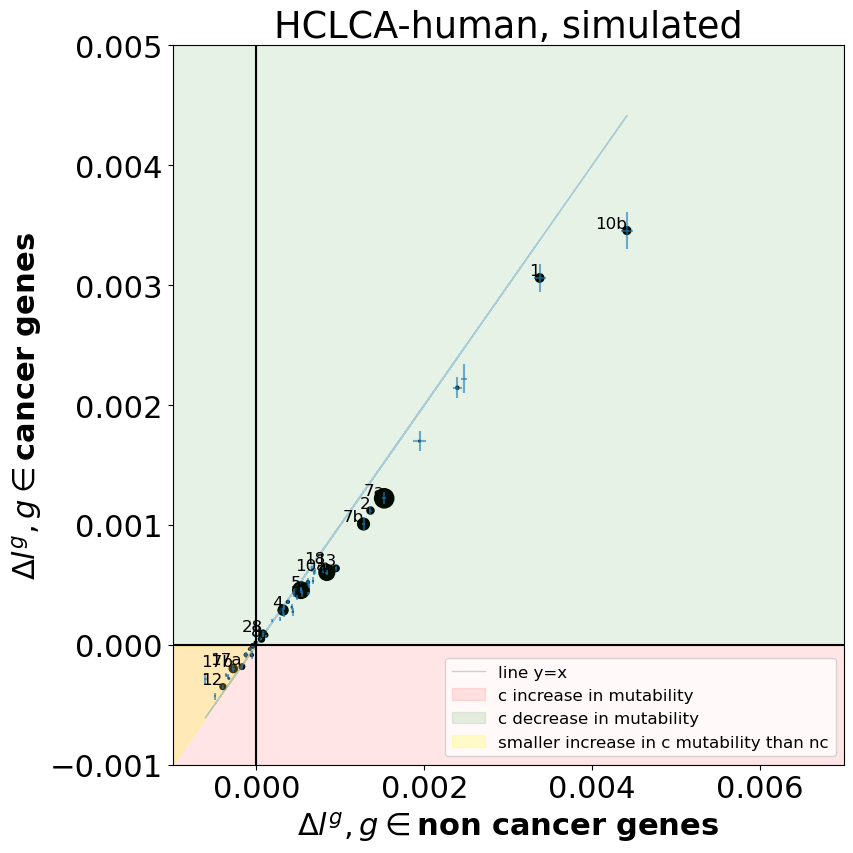

In [ ]:
cancer_genes = '/home/maria/run_simulations/data/Cosmic_CancerGeneCensus_names.txt'
gene_ids = '/home/maria/cactus_target_size/auxillary/gene_name_id.csv'
weights_file = '/home/maria/data/signature_weights/calc_mut_weights.csv'

no_of_sims =15
HCLCA_file ='/home/maria/run_simulations_cactus/output_anc4_hg38/Anc4/'
homo_file ="/home/maria/run_simulations_cactus/output_anc4_hg38/sim_{x}/"
title = 'HCLCA-human, simulated'

gene_id_df = pd.read_csv(gene_ids)

cancer_genes_df = pd.read_csv(cancer_genes, names=['gene_name'])
#convert cancer genes to ensembl gene ids
cancer_id_df = cancer_genes_df.merge(gene_id_df, on=['gene_name'], how='inner')
cancer_genes_list = cancer_id_df['gene'].tolist()
filtered_sum = pd.read_csv(weights_file, index_col=0, names=['norm_weight'])
HCLCA_df = extract_avg_l_per_sig(HCLCA_file, 'HCLCA', cancer_genes_list)


def safe_delta(A, B):
    denom = A + B
    out = (A - B) / denom
    out[denom == 0] = np.nan
    return out

c_delta_sims = []
nc_delta_sims = []

for i in range(no_of_sims):
    human_df = extract_avg_l_per_sig(homo_file.format(x=i), 'human', cancer_genes_list)
    # join the constants you need (HCLCA) just for this sim
    sim = human_df[['l_c_human','l_nc_human']].join(
        HCLCA_df[['l_c_HCLCA','l_nc_HCLCA']], how='inner'
    )

    c_delta_i  = safe_delta(sim['l_c_HCLCA'],  sim['l_c_human'])
    nc_delta_i = safe_delta(sim['l_nc_HCLCA'], sim['l_nc_human'])

    c_delta_sims.append(c_delta_i.rename(i))
    nc_delta_sims.append(nc_delta_i.rename(i))

# Stack sims column-wise
c_delta_mat  = pd.concat(c_delta_sims, axis=1)
nc_delta_mat = pd.concat(nc_delta_sims, axis=1)

# Mean and SEM across sims (rows = genes)
c_mean  = c_delta_mat.mean(axis=1)
c_sem   = c_delta_mat.sem(axis=1, ddof=1)  # standard error
nc_mean = nc_delta_mat.mean(axis=1)
nc_sem  = nc_delta_mat.sem(axis=1, ddof=1)

# Bring in weights (and ensure indices align)
plot_df = pd.DataFrame({'c_Delta': c_mean, 'nc_Delta': nc_mean}).join(
    filtered_sum[['norm_weight']], how='inner'
)

# Error bars aligned to plot_df index
cerr  = c_sem.reindex(plot_df.index)
ncerr = nc_sem.reindex(plot_df.index)

# Plot
plt.figure(figsize=(9,9))
plot_c_diff_against_nc_diff_error_bars(
    plot_df['c_Delta'], plot_df['nc_Delta'],
    cerr, ncerr,
    plot_df.index, plot_df['norm_weight'],
    title
)



instead of standard error plotting 95th qunatiles

number of genes is 17453
number of genes is 17453
number of genes is 17453
number of genes is 17453
number of genes is 17453
number of genes is 17453
number of genes is 17453
number of genes is 17453
number of genes is 17453
number of genes is 17453
number of genes is 17453
number of genes is 17453
number of genes is 17453
number of genes is 17453
number of genes is 17453
number of genes is 17453
number of genes is 17453
number of genes is 17453
number of genes is 17453
number of genes is 17453
number of genes is 17453
number of genes is 17453
number of genes is 17453
number of genes is 17453
number of genes is 17453
number of genes is 17453
number of genes is 17453
number of genes is 17453
number of genes is 17453
number of genes is 17453
number of genes is 17453
SBS10b
0.00441691452377935
0.003506329631106121


/tmp/ipykernel_12698/211290483.py:201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if sig_weights[i]>0.01:
/tmp/ipykernel_12698/211290483.py:207: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(nc_diff[i], c_diff[i], sig[3:], fontsize=12, ha='right', va='bottom', alpha=1)
/tmp/ipykernel_12698/211290483.py:205: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(nc_diff[i])
/tmp/ipykernel_12698/211290483.py:206: FutureWarnin

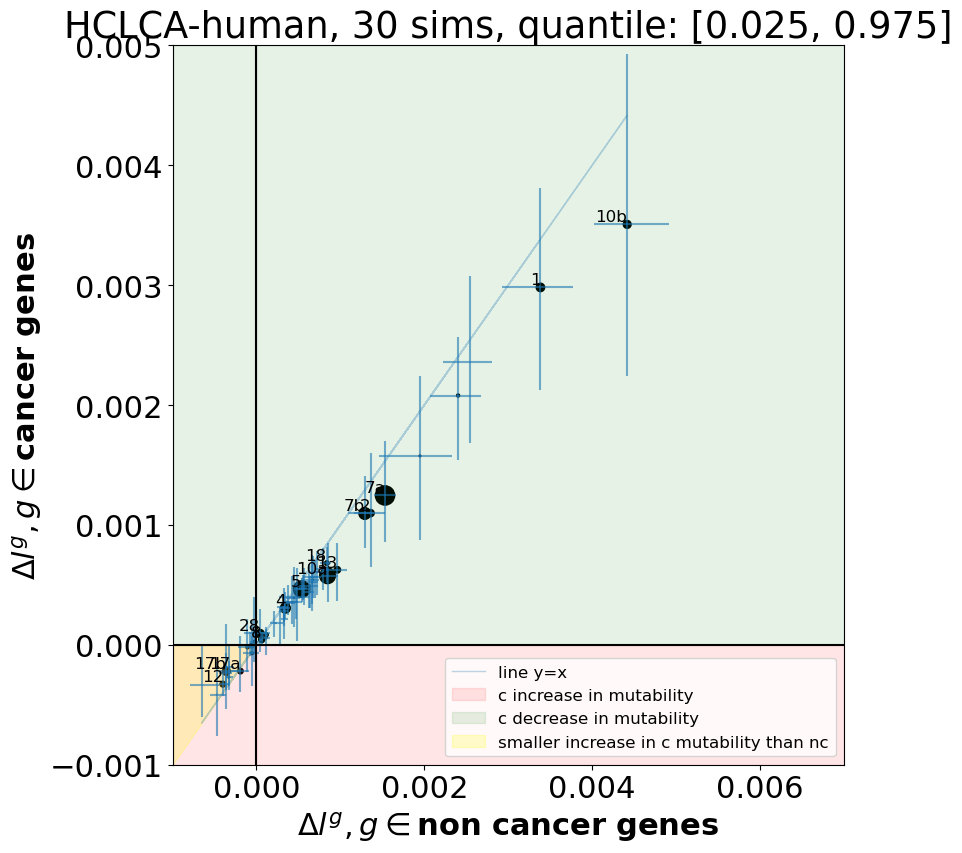

In [4]:
lower_quant_cutoff = 0.025
upper_quant_cutoff = 0.975
cancer_genes = '/home/maria/run_simulations/data/Cosmic_CancerGeneCensus_names.txt'
gene_ids = '/home/maria/cactus_target_size/auxillary/gene_name_id.csv'
weights_file = '/home/maria/data/signature_weights/calc_mut_weights.csv'

no_of_sims =30
HCLCA_file ='/home/maria/run_simulations_cactus/output_anc4_hg38/Anc4/'
homo_file ="/home/maria/run_simulations_cactus/output_anc4_hg38/sim_{x}/"
title = f'HCLCA-human, {no_of_sims} sims, quantile: {[lower_quant_cutoff,upper_quant_cutoff]}'

gene_id_df = pd.read_csv(gene_ids)

cancer_genes_df = pd.read_csv(cancer_genes, names=['gene_name'])
#convert cancer genes to ensembl gene ids
cancer_id_df = cancer_genes_df.merge(gene_id_df, on=['gene_name'], how='inner')
cancer_genes_list = cancer_id_df['gene'].tolist()
filtered_sum = pd.read_csv(weights_file, index_col=0, names=['norm_weight'])
HCLCA_df = extract_avg_l_per_sig(HCLCA_file, 'HCLCA', cancer_genes_list)


def safe_delta(A, B):
    denom = A + B
    out = (A - B) / denom
    out[denom == 0] = np.nan
    return out

c_delta_sims = []
nc_delta_sims = []
#for checking dist of l rather than delta
c_sims = []
nc_sims =[]

for i in range(no_of_sims):
    human_df = extract_avg_l_per_sig(homo_file.format(x=i), 'human', cancer_genes_list)
    # join the constants you need (HCLCA) just for this sim
    sim = human_df[['l_c_human','l_nc_human']].join(
        HCLCA_df[['l_c_HCLCA','l_nc_HCLCA']], how='inner'
    )

    c_delta_i  = safe_delta(sim['l_c_HCLCA'],  sim['l_c_human'])
    nc_delta_i = safe_delta(sim['l_nc_HCLCA'], sim['l_nc_human'])

    c_delta_sims.append(c_delta_i.rename(i))
    nc_delta_sims.append(nc_delta_i.rename(i))

    #to check l distn
    c_sims.append(sim['l_c_human'].rename(i))
    nc_sims.append(sim['l_nc_human'].rename(i))

#to see l dist, stack column wise
c_mat  = pd.concat(c_sims, axis=1)
nc_mat = pd.concat(nc_sims, axis=1)


# Stack sims column-wise
c_delta_mat  = pd.concat(c_delta_sims, axis=1)
nc_delta_mat = pd.concat(nc_delta_sims, axis=1)


# Mean across sims (rows = sigs)
c_mean  = c_delta_mat.mean(axis=1)
nc_mean = nc_delta_mat.mean(axis=1)

# Bring in weights (and ensure indices align)
plot_df = pd.DataFrame({'c_Delta': c_mean, 'nc_Delta': nc_mean}).join(
    filtered_sum[['norm_weight']], how='inner'
)

# compute absolute mean deltas first (if not already in plot_df)
c_mean  = plot_df["c_Delta"]
nc_mean = plot_df["nc_Delta"]

#could also try running with percentiles:
c_quantile = c_delta_mat.quantile([lower_quant_cutoff,upper_quant_cutoff],axis=1)
nc_quantile = nc_delta_mat.quantile([lower_quant_cutoff,upper_quant_cutoff],axis=1)

#reindex to allign
cerr_df  = c_quantile.T.reindex(plot_df.index)
ncerr_df = nc_quantile.T.reindex(plot_df.index)

#convert absolute quantiles to distances from the mean
c_lower = c_mean - cerr_df[lower_quant_cutoff]
c_upper = cerr_df[upper_quant_cutoff] - c_mean
n_lower = nc_mean - ncerr_df[lower_quant_cutoff]
n_upper = ncerr_df[upper_quant_cutoff] - nc_mean

# build error arrays for plt.errorbar
cerr  = [c_lower, c_upper]
ncerr = [n_lower, n_upper]

plt.figure(figsize=(9,9))
plot_c_diff_against_nc_diff_error_bars(
    plot_df['c_Delta'], plot_df['nc_Delta'],
    cerr, ncerr,
    plot_df.index, plot_df['norm_weight'],
    title
)


print signatures with decrease in susceptibility more than 97.5 qunatile

In [5]:
c_quant = c_delta_mat.quantile([0.05,0.975],axis=1)
nc_quant = nc_delta_mat.quantile([0.05,0.975],axis=1)

#reindex to allign
cerr2_df  = c_quant.T.reindex(weight_merged_df.index)
ncerr2_df = nc_quant.T.reindex(weight_merged_df.index)
check =cerr2_df[0.975]<weight_merged_df['c_Delta']
print(check[check].index.values)

check =ncerr2_df[0.975]<weight_merged_df['nc_Delta']

print(check[check].index.values)

['SBS42' 'SBS15' 'SBS26' 'SBS24' 'SBS25' 'SBS35' 'SBS1' 'SBS23' 'SBS44'
 'SBS87' 'SBS4' 'SBS31' 'SBS20' 'SBS21' 'SBS33' 'SBS29' 'SBS6']
['SBS42' 'SBS37' 'SBS15' 'SBS26' 'SBS24' 'SBS89' 'SBS86' 'SBS25' 'SBS7b'
 'SBS35' 'SBS1' 'SBS23' 'SBS44' 'SBS87' 'SBS4' 'SBS11' 'SBS31' 'SBS20'
 'SBS12' 'SBS21' 'SBS33' 'SBS29' 'SBS39' 'SBS17a' 'SBS6' 'SBS5']


sigs with decrease in susceptibility more than 95%

In [6]:
c_quant = c_delta_mat.quantile([0.025,0.975],axis=1)
nc_quant = nc_delta_mat.quantile([0.025,0.975],axis=1)

#reindex to allign
cerr2_df  = c_quant.T.reindex(weight_merged_df.index)
ncerr2_df = nc_quant.T.reindex(weight_merged_df.index)
check =cerr2_df[0.025]>weight_merged_df['c_Delta']
print(check[check].index.values)

check =ncerr2_df[0.025]>weight_merged_df['nc_Delta']

print(check[check].index.values)

['SBS7d' 'SBS28' 'SBS34' 'SBS8' 'SBS3' 'SBS13' 'SBS7a' 'SBS14' 'SBS19'
 'SBS2' 'SBS32' 'SBS30' 'SBS10a' 'SBS16' 'SBS36' 'SBS18' 'SBS90' 'SBS88'
 'SBS9' 'SBS17b' 'SBS85']
['SBS7d' 'SBS28' 'SBS34' 'SBS8' 'SBS3' 'SBS13' 'SBS7a' 'SBS84' 'SBS19'
 'SBS2' 'SBS32' 'SBS30' 'SBS10a' 'SBS16' 'SBS36' 'SBS18' 'SBS90' 'SBS88'
 'SBS9' 'SBS7c' 'SBS17b' 'SBS85']


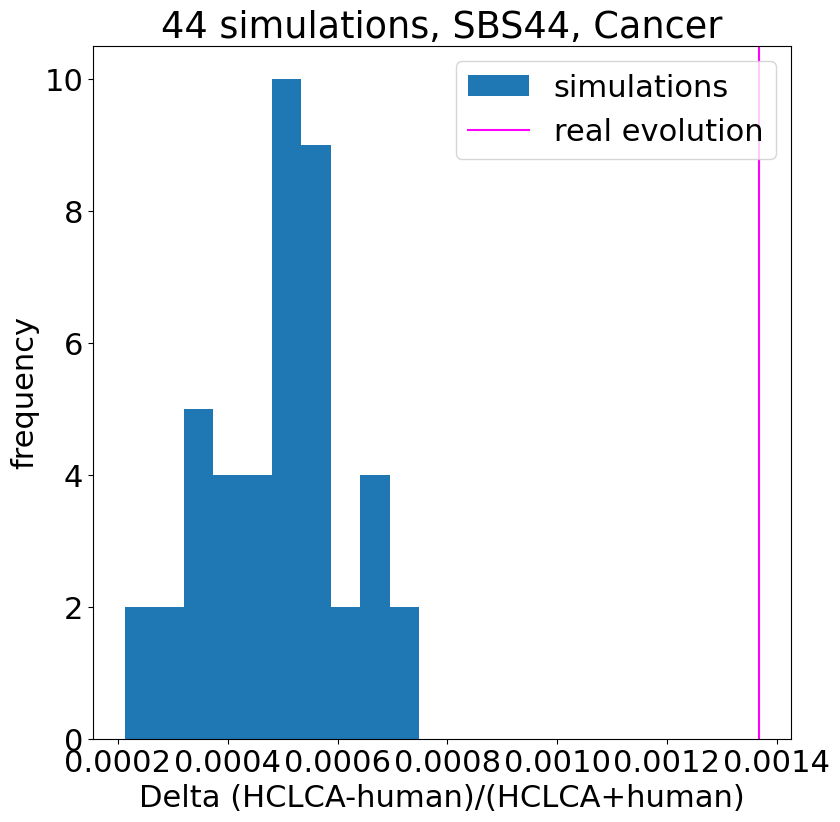

In [29]:
#testing distribution shape per sig
homo_file = '/home/maria/cactus_target_size/output_nocpg/hg38/'
#human_df = extract_avg_l_per_sig(homo_file, 'human', cancer_genes_list)
sig='SBS44'
plt.figure(figsize=(9,9))
plt.hist(c_delta_mat.loc[sig],label='simulations')
plt.xlabel('Delta (HCLCA-human)/(HCLCA+human)')
plt.ylabel('frequency')
plt.title(f'{no_of_sims} simulations, {sig}, Cancer')
# add lines separately
plt.axvline(x=weight_merged_df.loc[sig,'c_Delta'], color='magenta', label='real evolution')
plt.legend()

non cancer- simulated dist vs actual, per gene

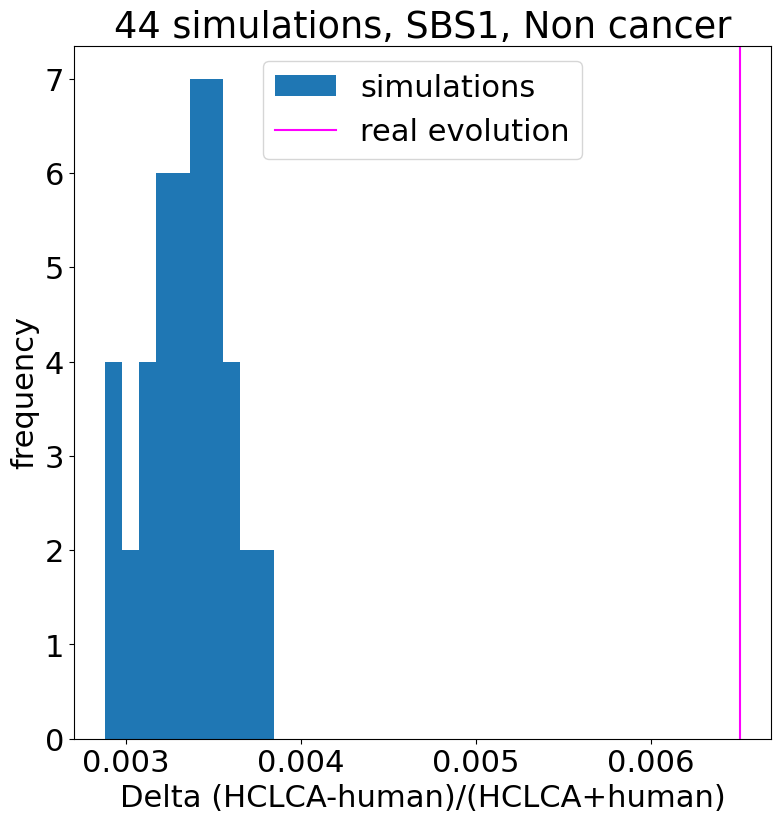

In [46]:
#testing distribution shape per sig
homo_file = '/home/maria/cactus_target_size/output_nocpg/hg38/'
#human_df = extract_avg_l_per_sig(homo_file, 'human', cancer_genes_list)
sig='SBS1'
plt.figure(figsize=(9,9))
plt.hist(nc_delta_mat.loc[sig],label='simulations')
plt.xlabel('Delta (HCLCA-human)/(HCLCA+human)')
plt.ylabel('frequency')
plt.title(f'{no_of_sims} simulations, {sig}, Non cancer')
# add lines separately
plt.axvline(x=weight_merged_df.loc[sig,'nc_Delta'], color='magenta', label='real evolution')
plt.legend()

comparing actual target size rather than relative chnage vs HCLCA 

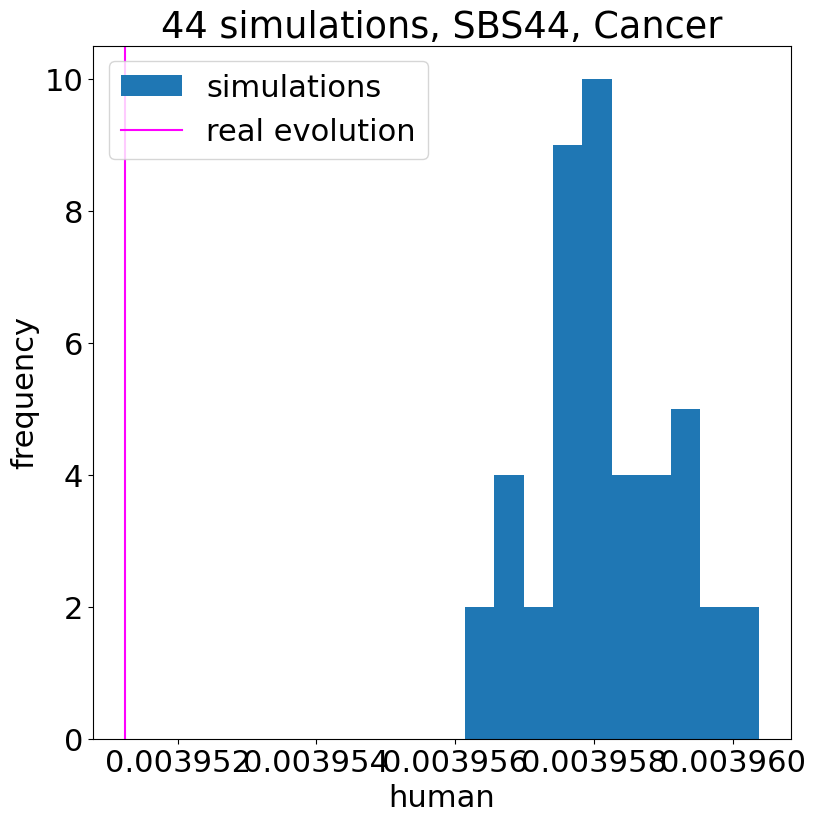

In [27]:
#testing distribution shape per sig
homo_file = '/home/maria/cactus_target_size/output_nocpg/hg38/'
#human_df = extract_avg_l_per_sig(homo_file, 'human', cancer_genes_list)
sig='SBS44'
plt.figure(figsize=(9,9))
plt.hist(c_mat.loc[sig],label='simulations')
plt.xlabel('human')
plt.ylabel('frequency')
plt.title(f'{no_of_sims} simulations, {sig}, Cancer')
# add lines separately
plt.axvline(x=merged_df.loc[sig,'l_c_human'], color='magenta', label='real evolution')
plt.legend()

In [ ]:
#redoing with matched cancer and non cancer genes:
matched_gene_file = '/home/maria/gene_matching/output/matched_genes.tsv'
matched_gene_df = pd.read_csv(matched_gene_file, index_col=0)

gene_dict = gene_id_df.set_index('gene')['gene_name'].to_dict()

human_df_match = extract_avg_l_per_sig_matched_genes(homo_file, 'human',  matched_gene_df, gene_dict)
HCLCA_df_match = extract_avg_l_per_sig_matched_genes(HCLCA_file, 'HCLCA',  matched_gene_df, gene_dict)

merged_df_match = human_df_match.join(HCLCA_df_match)

filtered_sum = pd.read_csv(weights_file, index_col=0, names=['norm_weight'])
weight_merged_df = merged_df_match.join(filtered_sum, how='inner')
weight_merged_df['c_Delta'] = (weight_merged_df['l_c_HCLCA']-weight_merged_df['l_c_human'])/( weight_merged_df['l_c_HCLCA']+weight_merged_df['l_c_human'])
weight_merged_df['nc_Delta'] = (weight_merged_df['l_nc_HCLCA']-weight_merged_df['l_nc_human'])/(weight_merged_df['l_nc_HCLCA']+weight_merged_df['l_nc_human'])


plt.figure(figsize=(9,9))
plot_c_diff_against_nc_diff(weight_merged_df['c_Delta'], weight_merged_df['nc_Delta'], weight_merged_df.index, weight_merged_df['norm_weight'], title)



In [ ]:
#looking at strongest gemrline signature, unnormalised
homo_file = '/home/maria/cactus_target_size/output/hg38/'
HCLCA_file = '/home/maria/cactus_target_size/output/anc/'
MRCA_sig_df = extract_sigs_per_gene(HCLCA_file)
homo_sig_df = extract_sigs_per_gene(homo_file)

diff_df = MRCA_sig_df - homo_sig_df
diff_df=diff_df.rename(index=gene_dict)
diff_df['sum'] = diff_df['SBS1'] +3* diff_df['SBS5']
diff_df.sort_values(by='sum',inplace=True, ascending=False)
selected_germ_df = diff_df[diff_df['sum']> 0]
selected_germ_df['norm'] = selected_germ_df['sum']/selected_germ_df['sum'].sum()

selected_germ_df['norm'][:500].to_csv('/home/maria/cactus_target_size/output/gene_list_SBS1_3SBS5.bed', header=False)

diff_df.sort_values(by='SBS7b',inplace=True, ascending=False)
diff_df['SBS7b'][:500].to_csv('/home/maria/cactus_target_size/output/gene_list_SBS7b.bed', header=False)


creating mean per sig across simulations to compute error bars

matching cancer and non cancer genes

number of genes is 18586
number of genes is 18584


<Figure size 640x480 with 0 Axes>

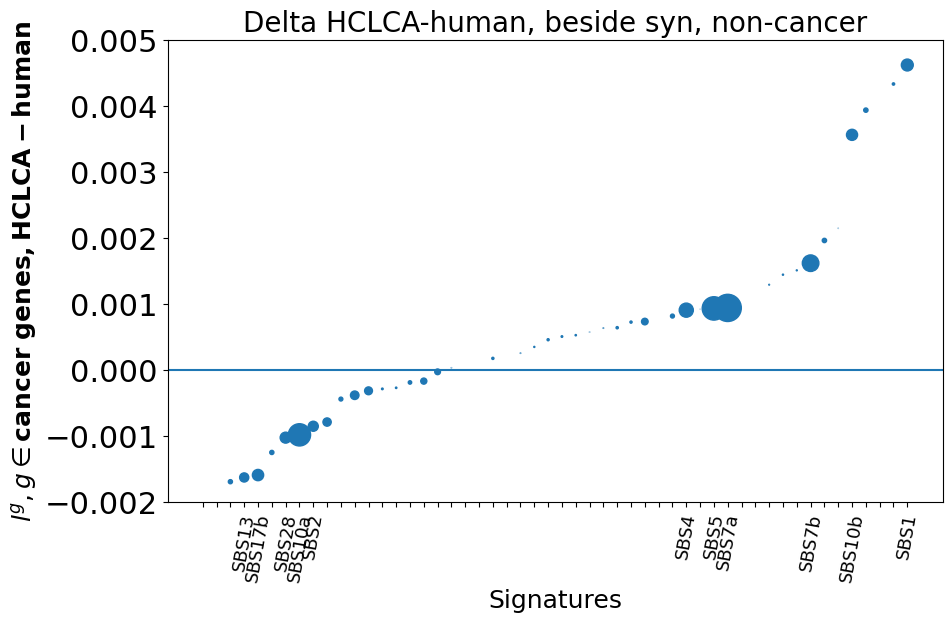

In [41]:
#need to account for differing content 


#plotting chnage in cancer genes, to compare to beside synonymous sites
cancer_genes = '/home/maria/run_simulations/data/Cosmic_CancerGeneCensus_names.txt'
gene_ids = '/home/maria/cactus_target_size/auxillary/gene_name_id.csv'
weights_file = '/home/maria/data/signature_weights/calc_mut_weights.csv'
'''
homo_file = '/home/maria/cactus_target_size/output/chimp/'
HCLCA_file = '/home/maria/cactus_target_size/output/anc/'
title = 'Delta HCLCA-human, all sites, non-cancer'
'''
HCLCA_file ='/home/maria/cactus_target_size/output_beside_syn/Anc4/'
homo_file ='/home/maria/cactus_target_size/output_beside_syn/hg38/'
title = 'Delta HCLCA-human, beside syn, non-cancer'

gene_id_df = pd.read_csv(gene_ids)

cancer_genes_df = pd.read_csv(cancer_genes, names=['gene_name'])
#convert cancer genes to ensembl gene ids
cancer_id_df = cancer_genes_df.merge(gene_id_df, on=['gene_name'], how='inner')
cancer_genes_list = cancer_id_df['gene'].tolist()

human_df = extract_avg_l_per_sig(homo_file, 'human', cancer_genes_list)
HCLCA_df = extract_avg_l_per_sig(HCLCA_file, 'HCLCA', cancer_genes_list)
merged_df = human_df.join(HCLCA_df)

filtered_sum = pd.read_csv(weights_file, index_col=0, names=['norm_weight'])
weight_merged_df = merged_df.join(filtered_sum, how='inner')

weight_merged_df['diff'] = (weight_merged_df['l_c_HCLCA']- weight_merged_df['l_c_human'])

weight_merged_df['diff'] = (weight_merged_df['l_nc_HCLCA']- weight_merged_df['l_nc_human'])/(weight_merged_df['l_nc_HCLCA']+ weight_merged_df['l_nc_human'])
weight_merged_df.sort_values('diff', ascending =True, inplace=True)

plt.figure()

plot_change_against_sig_weighted(weight_merged_df['diff'], weight_merged_df.index, weight_merged_df['norm_weight'], title)
